In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical

def load_data_from_mat(path):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith('train_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith('test_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels


def apply_fft_and_split(data):
    """
    对数据执行一维FFT变换，并分离实部和虚部。
    
    Parameters:
    - data: 形状为 (n_samples, n_features) 的数组
    
    Returns:
    - FFT变换后数据的实部和虚部
    """
    fft_data = np.fft.fft(data, axis=-1)
    return np.real(fft_data), np.imag(fft_data)

In [2]:
# 调用函数加载数据
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path)

train_data_origin = train_data
test_data_origin = test_data

# train_data_z = train_data / np.max(train_data)
# test_data_z = test_data / np.max(test_data)

# 应用FFT变换并分离实部和虚部
train_data_fft_real, train_data_fft_imag = apply_fft_and_split(train_data)
test_data_fft_real, test_data_fft_imag = apply_fft_and_split(test_data)

# 合并实部和虚部为模型的输入
train_data_fft_combined = np.concatenate((train_data_fft_real, train_data_fft_imag), axis=-1)
test_data_fft_combined = np.concatenate((test_data_fft_real, test_data_fft_imag), axis=-1)

def compute_magnitude_phase(data_fft_real, data_fft_imag):
    magnitude = np.sqrt(data_fft_real**2 + data_fft_imag**2)
    phase = np.arctan2(data_fft_imag, data_fft_real)
    return magnitude, phase

# 假设 train_data_fft_real 和 train_data_fft_imag 是你之前计算的FFT变换的实部和虚部
train_magnitude, train_phase = compute_magnitude_phase(train_data_fft_real, train_data_fft_imag)
test_magnitude, test_phase = compute_magnitude_phase(test_data_fft_real, test_data_fft_imag)

# 将幅度和相位合并为模型输入
# train_data_combined = np.concatenate((train_magnitude, train_phase), axis=-1)
# test_data_combined = np.concatenate((train_magnitude, train_phase), axis=-1)

half_train_magnitude = train_magnitude[:, :1536]
half_test_magnitude = test_magnitude[:, :1536]
half_train_data_fft_real = train_data_fft_real[:, :1536]
half_train_data_fft_imag = train_data_fft_imag[:, :1536]
half_test_data_fft_real = test_data_fft_real[:, :1536]
half_test_data_fft_imag = test_data_fft_imag[:, :1536]
# print(train_magnitude.shape)
# print(half_train_phase.shape)
# 然后可以用这些数据来训练你的模型
train_data_combined = np.concatenate((half_train_magnitude, half_train_data_fft_real, half_train_data_fft_imag), axis=-1)
test_data_combined = np.concatenate((half_test_magnitude, half_test_data_fft_real, half_test_data_fft_imag), axis=-1)
print(train_data_combined.shape)
print(test_data_combined.shape)
# train_data_fft_combined = np.concatenate((train_data_origin, train_data_combined), axis=-1)
# test_data_fft_combined = np.concatenate((test_data_origin, test_data_combined), axis=-1)
# print(train_data_fft_combined.shape)
# print(test_data_fft_combined.shape)
# print('Train data shape:', train_data_combined.shape)
# print('Train labels shape:', train_labels.shape)
# print('Test data shape:', test_data_combined.shape)
# print('Test labels shape:', test_labels.shape)
# # 根据FFT结果调整数据形状，此处仅为示例，实际需要根据FFT变换后的数据形状进行调整


(126000, 4608)
(14000, 4608)


In [3]:
# train_data_fft_reshaped = train_data_fft_combined.reshape((-1, 32, 48, 4))
# test_data_fft_reshaped = test_data_fft_combined.reshape((-1, 32, 48, 4))
train_data_fft_reshaped = train_data_combined.reshape((-1, 32, 48, 3))
test_data_fft_reshaped = test_data_combined.reshape((-1, 32, 48, 3))
print('Train data shape:', train_data_fft_reshaped.shape)
print('Test data shape:', test_data_fft_reshaped.shape)

Train data shape: (126000, 32, 48, 3)
Test data shape: (14000, 32, 48, 3)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_alexnet(input_shape=(32, 48, 3)):
    model = Sequential([
        Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # 10 classes
    ])
    
    return model

model = build_alexnet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 12, 96)      │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 12, 96)      │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 6, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 3, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 3, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 3, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,623,562 (82.49 MB)

 Trainable params: 21,622,858 (82.48 MB)

 Non-trainable params: 704 (2.75 KB)

In [5]:
# 训练模型
history = model.fit(train_data_fft_reshaped, train_labels,
                    batch_size=64,
                    epochs=30,  # 可以调整为合适的值
                    validation_split=0.1)



Epoch 1/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 503s 283ms/step - accuracy: 0.5052 - loss: 1.1132 - val_accuracy: 0.6106 - val_loss: 0.6183
Epoch 2/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 497s 280ms/step - accuracy: 0.6596 - loss: 0.7209 - val_accuracy: 0.6698 - val_loss: 0.5765
Epoch 3/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 504s 284ms/step - accuracy: 0.6808 - loss: 0.6707 - val_accuracy: 0.6222 - val_loss: 0.6307
Epoch 4/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 535s 302ms/step - accuracy: 0.7487 - loss: 0.5326 - val_accuracy: 0.6567 - val_loss: 0.6550
Epoch 5/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 521s 294ms/step - accuracy: 0.8118 - loss: 0.4171 - val_accuracy: 0.9199 - val_loss: 0.2542
Epoch 6/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 528s 298ms/step - accuracy: 0.8536 - loss: 0.3430 - val_accuracy: 0.8176 - val_loss: 0.4769
Epoch 7/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 528s 298ms/step - accuracy: 0.8762 - loss: 0.2929 - val_accuracy: 0.9356 - val_loss: 0.1721
Epoch 8/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 508s 286ms/step - ac

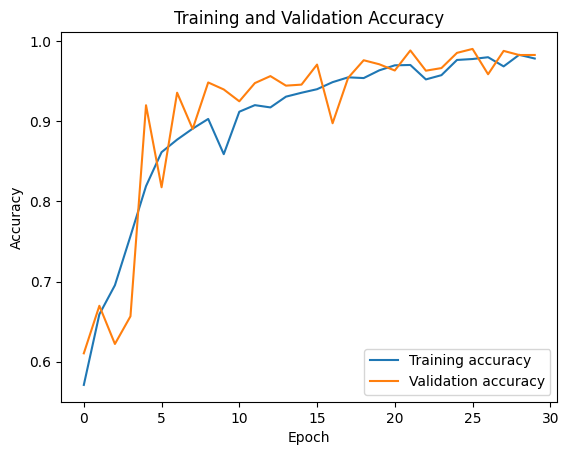

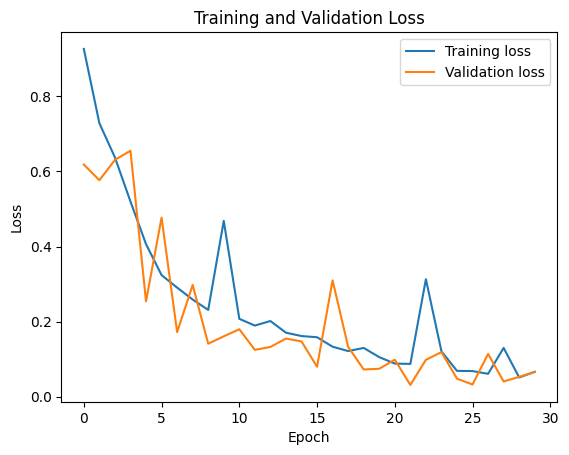

In [6]:
# 可视化训练过程
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
model.save('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-alexNet0330-6.h5')  # HDF5文件


In [3]:
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-alexNet0330-6.h5')
# 评估模型在测试集上的性能
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)

print(f'测试集损失: {test_loss}')
print(f'测试集准确率: {test_acc}')


NameError: name 'test_data_fft_reshaped' is not defined

438/438 - 8s - 17ms/step - accuracy: 0.8171 - loss: 0.9942

Test accuracy: 0.8170714378356934
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step
              precision    recall  f1-score   support

           0       0.59      0.81      0.68      1400
           1       1.00      1.00      1.00      1400
           2       0.89      0.93      0.91      1400
           3       0.93      0.86      0.89      1400
           4       1.00      1.00      1.00      1400
           5       1.00      0.90      0.95      1400
           6       0.74      0.53      0.61      1400
           7       1.00      1.00      1.00      1400
           8       0.56      0.62      0.59      1400
           9       0.56      0.52      0.54      1400

    accuracy                           0.82     14000
   macro avg       0.83      0.82      0.82     14000
weighted avg       0.83      0.82      0.82     14000



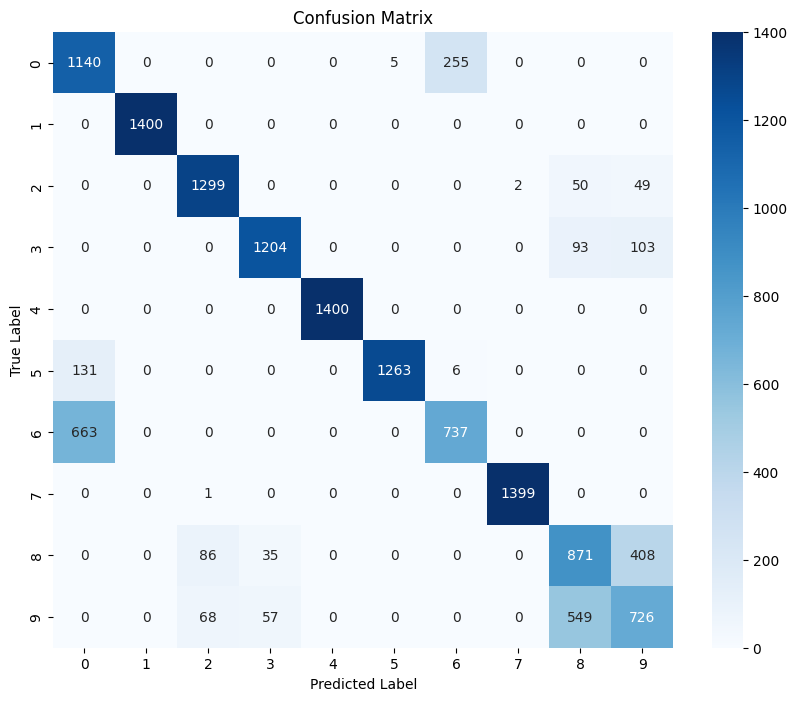

In [9]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


63/63 - 1s - 18ms/step - accuracy: 0.8079 - loss: 1.0435

Test accuracy: 0.8079039454460144
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.56      0.83      0.67       200
           1       1.00      1.00      1.00       200
           2       0.93      0.94      0.93       200
           3       0.91      0.87      0.89       200
           4       1.00      1.00      1.00       200
           5       1.00      0.85      0.92       200
           6       0.74      0.49      0.59       200
           7       1.00      1.00      1.00       200
           8       0.54      0.57      0.56       200
           9       0.53      0.52      0.53       199

    accuracy                           0.81      1999
   macro avg       0.82      0.81      0.81      1999
weighted avg       0.82      0.81      0.81      1999



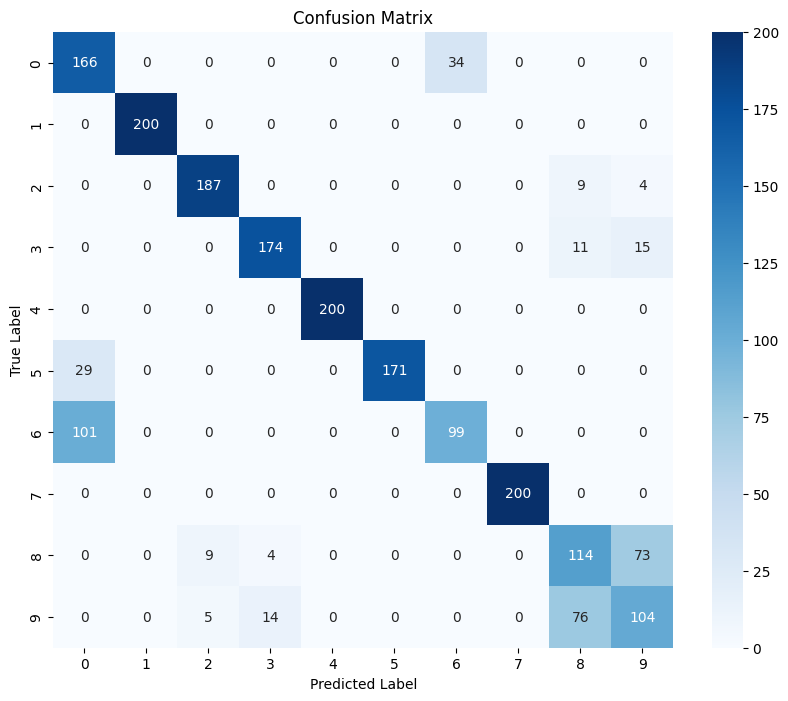

In [10]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped[0:1999], test_labels[0:1999], verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped[0:1999])
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels[0:1999].argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels[0:1999].argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


(2000, 4608)
63/63 - 1s - 16ms/step - accuracy: 0.8695 - loss: 0.8302

Test accuracy: 0.8694999814033508
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       200
           1       1.00      1.00      1.00       200
           2       0.97      0.95      0.96       200
           3       0.98      0.96      0.97       200
           4       1.00      1.00      1.00       200
           5       1.00      0.99      1.00       200
           6       0.75      0.60      0.66       200
           7       1.00      1.00      1.00       200
           8       0.67      0.78      0.72       200
           9       0.69      0.61      0.65       200

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



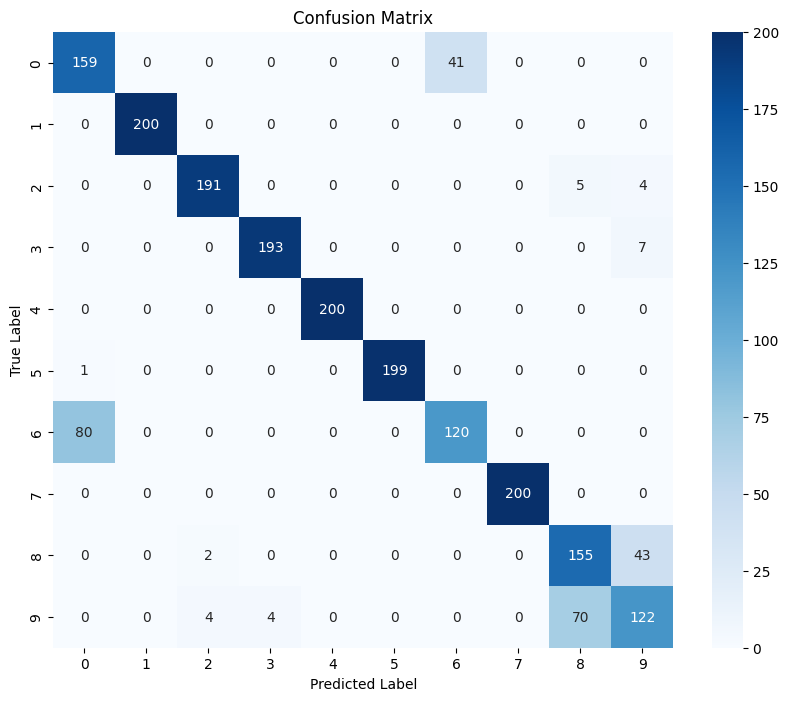

In [3]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-alexNet0330-6.h5')
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def load_data_from_mat(path,dBnumber):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith(f'train_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith(f'test_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    # print(test_data.shape, test_labels.shape)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels

def apply_fft_and_split(data):
    """
    对数据执行一维FFT变换，并分离实部和虚部。
    
    Parameters:
    - data: 形状为 (n_samples, n_features) 的数组
    
    Returns:
    - FFT变换后数据的实部和虚部
    """
    fft_data = np.fft.fft(data, axis=-1)
    return np.real(fft_data), np.imag(fft_data)

# 调用函数加载数据
dBnumber = 30
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path,dBnumber)


train_data_origin = train_data
test_data_origin = test_data

# train_data_z = train_data / np.max(train_data)
# test_data_z = test_data / np.max(test_data)

# 应用FFT变换并分离实部和虚部
train_data_fft_real, train_data_fft_imag = apply_fft_and_split(train_data)
test_data_fft_real, test_data_fft_imag = apply_fft_and_split(test_data)

# 合并实部和虚部为模型的输入
train_data_fft_combined = np.concatenate((train_data_fft_real, train_data_fft_imag), axis=-1)
test_data_fft_combined = np.concatenate((test_data_fft_real, test_data_fft_imag), axis=-1)

def compute_magnitude_phase(data_fft_real, data_fft_imag):
    magnitude = np.sqrt(data_fft_real**2 + data_fft_imag**2)
    phase = np.arctan2(data_fft_imag, data_fft_real)
    return magnitude, phase

# 假设 train_data_fft_real 和 train_data_fft_imag 是你之前计算的FFT变换的实部和虚部
test_magnitude, test_phase = compute_magnitude_phase(test_data_fft_real, test_data_fft_imag)


half_test_magnitude = test_magnitude[:, :1536]
half_test_data_fft_real = test_data_fft_real[:, :1536]
half_test_data_fft_imag = test_data_fft_imag[:, :1536]

# 然后可以用这些数据来训练你的模型

test_data_combined = np.concatenate((half_test_magnitude, half_test_data_fft_real, half_test_data_fft_imag), axis=-1)

print(test_data_combined.shape)

test_data_fft_reshaped = test_data_combined.reshape((-1, 32, 48, 3))

# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


(2000, 4608)
63/63 - 1s - 16ms/step - accuracy: 0.7670 - loss: 1.0683

Test accuracy: 0.7670000195503235
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

           0       0.55      0.82      0.66       200
           1       1.00      1.00      1.00       200
           2       0.82      0.83      0.82       200
           3       0.85      0.78      0.81       200
           4       1.00      1.00      1.00       200
           5       0.99      0.81      0.89       200
           6       0.74      0.52      0.61       200
           7       1.00      1.00      1.00       200
           8       0.43      0.41      0.42       200
           9       0.46      0.50      0.48       200

    accuracy                           0.77      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.78      0.77      0.77      2000



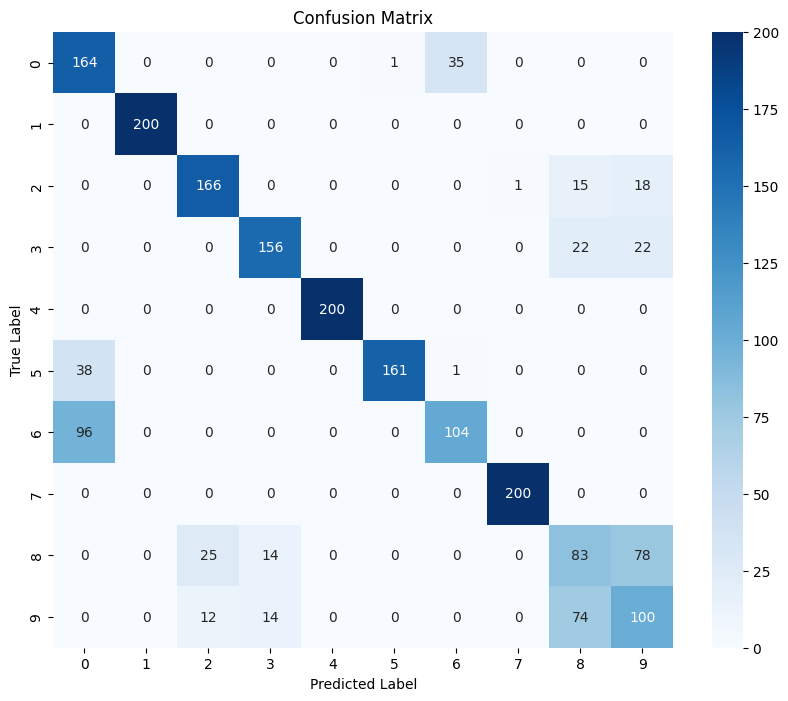

In [4]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-alexNet0330-6.h5')
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def load_data_from_mat(path,dBnumber):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith(f'train_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith(f'test_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    # print(test_data.shape, test_labels.shape)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels

def apply_fft_and_split(data):
    """
    对数据执行一维FFT变换，并分离实部和虚部。
    
    Parameters:
    - data: 形状为 (n_samples, n_features) 的数组
    
    Returns:
    - FFT变换后数据的实部和虚部
    """
    fft_data = np.fft.fft(data, axis=-1)
    return np.real(fft_data), np.imag(fft_data)

# 调用函数加载数据
dBnumber = 5
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path,dBnumber)


train_data_origin = train_data
test_data_origin = test_data

# train_data_z = train_data / np.max(train_data)
# test_data_z = test_data / np.max(test_data)

# 应用FFT变换并分离实部和虚部
train_data_fft_real, train_data_fft_imag = apply_fft_and_split(train_data)
test_data_fft_real, test_data_fft_imag = apply_fft_and_split(test_data)

# 合并实部和虚部为模型的输入
train_data_fft_combined = np.concatenate((train_data_fft_real, train_data_fft_imag), axis=-1)
test_data_fft_combined = np.concatenate((test_data_fft_real, test_data_fft_imag), axis=-1)

def compute_magnitude_phase(data_fft_real, data_fft_imag):
    magnitude = np.sqrt(data_fft_real**2 + data_fft_imag**2)
    phase = np.arctan2(data_fft_imag, data_fft_real)
    return magnitude, phase

# 假设 train_data_fft_real 和 train_data_fft_imag 是你之前计算的FFT变换的实部和虚部
test_magnitude, test_phase = compute_magnitude_phase(test_data_fft_real, test_data_fft_imag)


half_test_magnitude = test_magnitude[:, :1536]
half_test_data_fft_real = test_data_fft_real[:, :1536]
half_test_data_fft_imag = test_data_fft_imag[:, :1536]

# 然后可以用这些数据来训练你的模型

test_data_combined = np.concatenate((half_test_magnitude, half_test_data_fft_real, half_test_data_fft_imag), axis=-1)

print(test_data_combined.shape)

test_data_fft_reshaped = test_data_combined.reshape((-1, 32, 48, 3))

# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
